In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import datetime
import numpy as np

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier

In [5]:
import requests
import pandas as pd
import time
import os
from datetime import datetime

### 심볼 불러오기
result = requests.get('https://api.binance.com/api/v3/ticker/price')
js = result.json()
symbols = ['PSGUSDT']
symbols_usdt = [x for x in symbols if 'USDT' in x]  # 끝이 USDT로 끝나는 심볼들, ['BTCUSDT', 'ETHUSDT', ...]

### 데이터 불러오기

# 가져오는 데이터의 column
COLUMNS = ['Open_time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_time', 'quote_av', 'trades',
                   'tb_base_av', 'tb_quote_av', 'ignore']

# 조회하는 URL 주소
URL = 'https://api.binance.com/api/v3/klines'

# 함수
def get_data(start_date, end_date, symbol):
    data = []

    start = int(time.mktime(datetime.strptime(start_date + ' 00:00', '%Y-%m-%d %H:%M').timetuple())) * 1000
    end = int(time.mktime(datetime.strptime(end_date + ' 23:59', '%Y-%m-%d %H:%M').timetuple())) * 1000
    params = {
        'symbol': symbol,
        'interval': '1m', # 76번째 줄도 바꿔야 함 # 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M
        'limit': 1000,
        'startTime': start,
        'endTime': end
    }

    while start < end:
        print(datetime.fromtimestamp(start // 1000))
        params['startTime'] = start
        result = requests.get(URL, params=params)
        js = result.json()
        if not js:
            break
        data.extend(js)  # result에 저장
        start = js[-1][0] + 60000  # 다음 step으로
    # 전처리
    if not data:  # 해당 기간에 데이터가 없는 경우
        print('해당 기간에 일치하는 데이터가 없습니다.')
        return -1
    df = pd.DataFrame(data)
    df.columns = COLUMNS
    df['Open_time'] = df.apply(lambda x: datetime.fromtimestamp(x['Open_time'] // 1000), axis=1)
    df = df.drop(columns=['Close_time', 'ignore'])
    df['Symbol'] = symbol
    df.loc[:, 'Open':'tb_quote_av'] = df.loc[:, 'Open':'tb_quote_av'].astype(float)  # string to float
    df['trades'] = df['trades'].astype(int)
    return df

# # 시작시간, 종료시간 입력
# start_date = '2021-12-15'
# end_date = '2022-02-01'
# symbol = symbols_usdt[0]
# data = get_data(start_date,end_date,symbol)

# # CSV 파일로 저장


### 모든 데이터 csv로 저장
# 티커 이름 - 타임프레임별 저장

# 1분 데이터부터 - 시간은 위의 interval 바꿔줘야 함

interval = '1m' # 33번째 줄 참고

# 1년 단위 데이터

years = list(range(2018,2023))  # 바이낸스에서는 2017년 8월 이후의 데이터부터 제공하므로, 이때부터 있는 모든 데이터 긁어오기

for symbol in symbols_usdt[:10]:
    try:
        os.makedirs(f'C:.\\Data\\{symbol[:-4]}-USDT_Data')
        for year in years: # 연도별 자료 백테스트
            start_date = f'{year}-01-01'
            end_date = f'{year}-12-31'
            try:
                try:
                    os.makedirs(f'C:.\\Data\\{symbol[:-4]}-USDT_Data\\{symbol[:-4]}-USDT_Data_{interval}')  # 티커명으로 폴더 만들기 ex. BTC/USDT
                    df = get_data(start_date, end_date, symbol)
                    df.to_csv(f'C:.\\Data\\{symbol[:-4]}-USDT_Data\\{symbol[:-4]}-USDT_Data_{interval}\\{symbol[:-4].upper()}_USDT_{interval}_{year}.csv',index=False)  # 긁어온 데이터를 csv파일로 저장
                    time.sleep(1)  # 과다한 요청으로 API사용이 제한되는것을 막기 위해
                except AttributeError:
                    pass

            except FileExistsError:  # 이미 디렉토리가 만들어져 있을 경우 실행
                try:
                    print(f"이미 {symbol[:-4]}-USDT_{interval} 디렉토리 만들어져 있습니다")
                    df = get_data(start_date, end_date, symbol)
                    df.to_csv(f'C:.\\Data\\{symbol[:-4]}-USDT_Data\\{symbol[:-4]}-USDT_Data_{interval}\\{symbol[:-4].upper()}_USDT_{interval}_{year}.csv', index=False)  # 긁어온 데이터를 csv파일로 저장
                    time.sleep(1)  # 과다한 요청으로 API사용이 제한되는것을 막기 위해
                except AttributeError:
                    pass

    except FileExistsError: # 이미 디렉토리가 만들어져 있을 경우 실행
        print (f"이미 {symbol[:-4]}-USDT 디렉토리가 만들어져 있습니다")
        for year in years: # 연도별 자료 백테스트
            start_date = f'{year}-01-01'
            end_date = f'{year}-12-31'
            try:
                try:
                    os.makedirs(f'C:.\\Data\\{symbol[:-4]}-USDT_Data\\{symbol[:-4]}-USDT_Data_{interval}')  # 티커명으로 폴더 만들기 ex. BTC/USDT
                    df = get_data(start_date, end_date, symbol)
                    df.to_csv(
                        f'C:.\\Data\\{symbol[:-4]}-USDT_Data\\{symbol[:-4]}-USDT_Data_{interval}\\{symbol[:-4].upper()}_USDT_{interval}_{year}.csv',
                        index=False)  # 긁어온 데이터를 ㄴcsv파일로 저장
                    time.sleep(1)  # 과다한 요청으로 API사용이 제한되는것을 막기 위해
                except AttributeError:
                    pass

            except FileExistsError:  # 이미 디렉토리가 만들어져 있을 경우 실행
                try:
                    print(f"이미 {symbol[:-4]}-USDT_{interval} 디렉토리가 만들어져 있습니다")
                    df = get_data(start_date, end_date, symbol)
                    df.to_csv(f'C:.\\Data\\{symbol[:-4]}-USDT_Data\\{symbol[:-4]}-USDT_Data_{interval}\\{symbol[:-4].upper()}_USDT_{interval}_{year}.csv', index=False)  # 긁어온 데이터를 ㄴcsv파일로 저장
                    time.sleep(1)  # 과다한 요청으로 API사용이 제한되는것을 막기 위해
                except AttributeError:
                    pass

# 전체 연도 통합

years = list (range(2017,2023))
for symbol in symbols_usdt[:10]:
    try:
        os.makedirs(f'C:.\\Data\\{symbol[:-4]}-USDT_Data')
        start_date = f'{years[0]}-01-01'
        end_date = f'{years[-1]}-12-31'
        try:
            try:
                os.makedirs(f'C:.\\Data\\{symbol[:-4]}-USDT_Data\\{symbol[:-4]}-USDT_Data_{interval}')  # 티커명으로 폴더 만들기 ex. BTC/USDT
                df = get_data(start_date, end_date, symbol)
                df.to_csv(f'C:.\\Data\\{symbol[:-4]}-USDT_Data\\{symbol[:-4]}-USDT_Data_{interval}\\{symbol[:-4].upper()}_USDT_{interval}_All.csv',index=False)  # 긁어온 데이터를 csv파일로 저장
                time.sleep(1)  # 과다한 요청으로 API사용이 제한되는것을 막기 위해
            except AttributeError:
                pass

        except FileExistsError:  # 이미 디렉토리가 만들어져 있을 경우 실행
            try:
                print(f"이미 {symbol[:-4]}-USDT_{interval} 디렉토리 만들어져 있습니다")
                df = get_data(start_date, end_date, symbol)
                df.to_csv(f'C:.\\Data\\{symbol[:-4]}-USDT_Data\\{symbol[:-4]}-USDT_Data_{interval}\\{symbol[:-4].upper()}_USDT_{interval}_All.csv', index=False)  # 긁어온 데이터를 csv파일로 저장
                time.sleep(1)  # 과다한 요청으로 API사용이 제한되는것을 막기 위해
            except AttributeError:
                pass

    except FileExistsError: # 이미 디렉토리가 만들어져 있을 경우 실행
        print (f"이미 {symbol[:-4]}-USDT 디렉토리가 만들어져 있습니다")
        start_date = f'{years[0]}-01-01'
        end_date = f'{years[-1]}-12-31'
        try:
            try:
                os.makedirs(f'C:.\\Data\\{symbol[:-4]}-USDT_Data\\{symbol[:-4]}-USDT_Data_{interval}')  # 티커명으로 폴더 만들기 ex. BTC/USDT
                df = get_data(start_date, end_date, symbol)
                df.to_csv(
                    f'C:.\\Data\\{symbol[:-4]}-USDT_Data\\{symbol[:-4]}-USDT_Data_{interval}\\{symbol[:-4].upper()}_USDT_{interval}_All.csv',
                    index=False)  # 긁어온 데이터를 ㄴcsv파일로 저장
                time.sleep(1)  # 과다한 요청으로 API사용이 제한되는것을 막기 위해
            except AttributeError:
                pass

        except FileExistsError:  # 이미 디렉토리가 만들어져 있을 경우 실행
            try:
                print(f"이미 {symbol[:-4]}-USDT_{interval} 디렉토리가 만들어져 있습니다")
                df = get_data(start_date, end_date, symbol)
                df.to_csv(f'C:.\\Data\\{symbol[:-4]}-USDT_Data\\{symbol[:-4]}-USDT_Data_{interval}\\{symbol[:-4].upper()}_USDT_{interval}_All.csv', index=False)  # 긁어온 데이터를 ㄴcsv파일로 저장
                time.sleep(1)  # 과다한 요청으로 API사용이 제한되는것을 막기 위해
            except AttributeError:
                pass


2018-01-01 00:00:00
해당 기간에 일치하는 데이터가 없습니다.
이미 PSG-USDT_1m 디렉토리 만들어져 있습니다
2019-01-01 00:00:00
해당 기간에 일치하는 데이터가 없습니다.
이미 PSG-USDT_1m 디렉토리 만들어져 있습니다
2020-01-01 00:00:00
2020-12-22 11:52:00
2020-12-23 04:32:00
2020-12-23 21:12:00
2020-12-24 13:52:00
2020-12-25 06:32:00
2020-12-26 00:12:00
2020-12-26 16:52:00
2020-12-27 09:32:00
2020-12-28 02:12:00
2020-12-28 18:52:00
2020-12-29 11:32:00
2020-12-30 04:12:00
2020-12-30 20:52:00
2020-12-31 13:32:00


C:\Users\asaf0\AppData\Local\Temp/ipykernel_26168/4291552763.py:54: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Open':'tb_quote_av'] = df.loc[:, 'Open':'tb_quote_av'].astype(float)  # string to float


이미 PSG-USDT_1m 디렉토리 만들어져 있습니다
2021-01-01 00:00:00
2021-01-01 16:40:00
2021-01-02 09:20:00
2021-01-03 02:00:00
2021-01-03 18:40:00
2021-01-04 11:20:00
2021-01-05 04:00:00
2021-01-05 20:40:00
2021-01-06 13:20:00
2021-01-07 06:00:00
2021-01-07 22:40:00
2021-01-08 15:20:00
2021-01-09 08:00:00
2021-01-10 00:40:00
2021-01-10 17:20:00
2021-01-11 10:00:00
2021-01-12 02:40:00
2021-01-12 19:20:00
2021-01-13 12:00:00
2021-01-14 04:40:00
2021-01-14 21:20:00
2021-01-15 14:00:00
2021-01-16 06:40:00
2021-01-16 23:20:00
2021-01-17 16:00:00
2021-01-18 08:40:00
2021-01-19 01:20:00
2021-01-19 18:00:00
2021-01-20 10:40:00
2021-01-21 03:20:00
2021-01-21 20:00:00
2021-01-22 12:40:00
2021-01-23 05:20:00
2021-01-23 22:00:00
2021-01-24 14:40:00
2021-01-25 07:20:00
2021-01-26 00:00:00
2021-01-26 16:40:00
2021-01-27 09:20:00
2021-01-28 02:00:00
2021-01-28 18:40:00
2021-01-29 11:20:00
2021-01-30 04:00:00
2021-01-30 20:40:00
2021-01-31 13:20:00
2021-02-01 06:00:00
2021-02-01 22:40:00
2021-02-02 15:20:00
2021-02-03

C:\Users\asaf0\AppData\Local\Temp/ipykernel_26168/4291552763.py:54: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Open':'tb_quote_av'] = df.loc[:, 'Open':'tb_quote_av'].astype(float)  # string to float


이미 PSG-USDT_1m 디렉토리 만들어져 있습니다
2022-01-01 00:00:00
2022-01-01 16:40:00
2022-01-02 09:20:00
2022-01-03 02:00:00
2022-01-03 18:40:00
2022-01-04 11:20:00
2022-01-05 04:00:00
2022-01-05 20:40:00
2022-01-06 13:20:00
2022-01-07 06:00:00
2022-01-07 22:40:00
2022-01-08 15:20:00
2022-01-09 08:00:00
2022-01-10 00:40:00
2022-01-10 17:20:00
2022-01-11 10:00:00
2022-01-12 02:40:00
2022-01-12 19:20:00
2022-01-13 12:00:00
2022-01-14 04:40:00
2022-01-14 21:20:00
2022-01-15 14:00:00
2022-01-16 06:40:00
2022-01-16 23:20:00
2022-01-17 16:00:00
2022-01-18 08:40:00
2022-01-19 01:20:00
2022-01-19 18:00:00
2022-01-20 10:40:00
2022-01-21 03:20:00
2022-01-21 20:00:00
2022-01-22 12:40:00
2022-01-23 05:20:00
2022-01-23 22:00:00
2022-01-24 14:40:00
2022-01-25 07:20:00
2022-01-26 00:00:00
2022-01-26 16:40:00
2022-01-27 09:20:00
2022-01-28 02:00:00
2022-01-28 18:40:00
2022-01-29 11:20:00
2022-01-30 04:00:00
2022-01-30 20:40:00
2022-01-31 13:20:00
2022-02-01 06:00:00
2022-02-01 22:40:00
2022-02-02 15:20:00
2022-02-03

C:\Users\asaf0\AppData\Local\Temp/ipykernel_26168/4291552763.py:54: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Open':'tb_quote_av'] = df.loc[:, 'Open':'tb_quote_av'].astype(float)  # string to float


이미 PSG-USDT 디렉토리가 만들어져 있습니다
이미 PSG-USDT_1m 디렉토리가 만들어져 있습니다
2017-01-01 00:00:00
2020-12-22 11:52:00
2020-12-23 04:32:00
2020-12-23 21:12:00
2020-12-24 13:52:00
2020-12-25 06:32:00
2020-12-26 00:12:00
2020-12-26 16:52:00
2020-12-27 09:32:00
2020-12-28 02:12:00
2020-12-28 18:52:00
2020-12-29 11:32:00
2020-12-30 04:12:00
2020-12-30 20:52:00
2020-12-31 13:32:00
2021-01-01 06:12:00
2021-01-01 22:52:00
2021-01-02 15:32:00
2021-01-03 08:12:00
2021-01-04 00:52:00
2021-01-04 17:32:00
2021-01-05 10:12:00
2021-01-06 02:52:00
2021-01-06 19:32:00
2021-01-07 12:12:00
2021-01-08 04:52:00
2021-01-08 21:32:00
2021-01-09 14:12:00
2021-01-10 06:52:00
2021-01-10 23:32:00
2021-01-11 16:12:00
2021-01-12 08:52:00
2021-01-13 01:32:00
2021-01-13 18:12:00
2021-01-14 10:52:00
2021-01-15 03:32:00
2021-01-15 20:12:00
2021-01-16 12:52:00
2021-01-17 05:32:00
2021-01-17 22:12:00
2021-01-18 14:52:00
2021-01-19 07:32:00
2021-01-20 00:12:00
2021-01-20 16:52:00
2021-01-21 09:32:00
2021-01-22 02:12:00
2021-01-22 18:52:00
2

C:\Users\asaf0\AppData\Local\Temp/ipykernel_26168/4291552763.py:54: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Open':'tb_quote_av'] = df.loc[:, 'Open':'tb_quote_av'].astype(float)  # string to float


In [6]:
df = pd.read_csv('./Data/PSG-USDT_Data/PSG-USDT_Data_1m/PSG_USDT_1m_All.csv')
df

,Open_time,Open,High,Low,Close,Volume,quote_av,trades,tb_base_av,tb_quote_av,Symbol
0,2020-12-21 15:00:00,12.880,29.339,10.000,26.339,45094.971,1.038826e+06,2503,30740.529,709912.790954,PSGUSDT
1,2020-12-21 15:01:00,26.784,35.400,25.311,26.999,43021.838,1.315848e+06,2666,20313.705,621996.379824,PSGUSDT
2,2020-12-21 15:02:00,26.998,27.005,23.750,25.610,28382.859,7.221227e+05,1689,16052.017,409591.864707,PSGUSDT
3,2020-12-21 15:03:00,25.615,25.994,24.549,24.995,15617.606,3.915451e+05,990,8986.626,225379.013359,PSGUSDT
4,2020-12-21 15:04:00,24.990,25.500,24.767,24.902,9433.048,2.362146e+05,613,4093.631,102729.625357,PSGUSDT
...,...,...,...,...,...,...,...,...,...,...,...
1064831,2022-12-31 23:55:00,5.480,5.480,5.480,5.480,0.000,0.000000e+00,0,0.000,0.000000,PSGUSDT
1064832,2022-12-31 23:56:00,5.470,5.480,5.470,5.470,400.870,2.193520e+03,15,76.130,417.192400,PSGUSDT
1064833,2022-12-31 23:57:00,5.480,5.490,5.480,5.490,282.580,1.549469e+03,20,282.580,1549.469500,PSGUSDT
1064834,2022-12-31 23:58:00,5.480,5.480,5.480,5.480,77.020,4.220696e+02,4,0.000,0.000000,PSGUSDT


In [7]:
df['Return'] = df['Close'].pct_change() # Return 계산
df['Maximum Hour Return'] = df['Return'].rolling(window=60).max() # Calculate maximum return
df['Price Volatility'] = df['Close'].rolling(window=60).std() # Minutewise price volatility
df['Return Volatility'] = df['Return'].rolling(window=60).std()  # Minutewise return volatility
for n in [60, 180, 240, 720, 1440]:  # 1, 3, 6, 12, 24 hours *Calculate momentums
    df[f'Momentum {n//60}H'] = df['Close'].pct_change(n)
df['Maximum Daily Return'] = df['Return'].rolling(window=2880).max()
df['Avg Price'] = df['Close'].rolling(window=60).mean() # Calculate average return for 1 hour

In [8]:
df = df.tail(100000)
df

,Open_time,Open,High,Low,Close,Volume,quote_av,trades,tb_base_av,tb_quote_av,...,Maximum Hour Return,Price Volatility,Return Volatility,Momentum 1H,Momentum 3H,Momentum 4H,Momentum 12H,Momentum 24H,Maximum Daily Return,Avg Price
964836,2022-10-23 13:20:00,6.60,6.60,6.58,6.58,11.10,73.1171,3,1.86,12.2760,...,0.003040,0.013148,0.001349,-0.004539,0.009202,0.004580,0.012308,0.020155,0.006667,6.600000
964837,2022-10-23 13:21:00,6.60,6.60,6.60,6.60,17.21,113.5860,4,17.21,113.5860,...,0.003040,0.013083,0.001408,-0.001513,0.012270,0.007634,0.015385,0.023256,0.006667,6.599833
964838,2022-10-23 13:22:00,6.60,6.60,6.60,6.60,0.00,0.0000,0,0.00,0.0000,...,0.003040,0.013083,0.001394,0.000000,0.012270,0.007634,0.016949,0.024845,0.006667,6.599833
964839,2022-10-23 13:23:00,6.60,6.60,6.60,6.60,1.98,13.0680,1,1.98,13.0680,...,0.003040,0.013083,0.001394,0.000000,0.013825,0.007634,0.016949,0.024845,0.006667,6.599833
964840,2022-10-23 13:24:00,6.60,6.60,6.60,6.60,0.00,0.0000,0,0.00,0.0000,...,0.003040,0.013083,0.001394,0.000000,0.013825,0.007634,0.016949,0.024845,0.006667,6.599833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064831,2022-12-31 23:55:00,5.48,5.48,5.48,5.48,0.00,0.0000,0,0.00,0.0000,...,0.003650,0.008732,0.001300,0.000000,0.001828,0.001828,0.007353,0.016698,0.011029,5.485167
1064832,2022-12-31 23:56:00,5.47,5.48,5.47,5.47,400.87,2193.5202,15,76.13,417.1924,...,0.003650,0.008727,0.001230,-0.005455,0.001832,0.000000,0.005515,0.014842,0.011029,5.484667
1064833,2022-12-31 23:57:00,5.48,5.49,5.48,5.49,282.58,1549.4695,20,282.58,1549.4695,...,0.003656,0.008732,0.001233,0.001825,0.005495,0.003656,0.009191,0.018553,0.011029,5.484833
1064834,2022-12-31 23:58:00,5.48,5.48,5.48,5.48,77.02,422.0696,4,0.00,0.0000,...,0.003656,0.008732,0.001256,0.000000,0.003663,0.001828,0.007353,0.014815,0.011029,5.484833


In [9]:
print(df.columns)

Index(['Open_time', 'Open', 'High', 'Low', 'Close', 'Volume', 'quote_av',
       'trades', 'tb_base_av', 'tb_quote_av', 'Symbol', 'Return',
       'Maximum Hour Return', 'Price Volatility', 'Return Volatility',
       'Momentum 1H', 'Momentum 3H', 'Momentum 4H', 'Momentum 12H',
       'Momentum 24H', 'Maximum Daily Return', 'Avg Price'],
      dtype='object')


Text(0, 0.5, 'price')

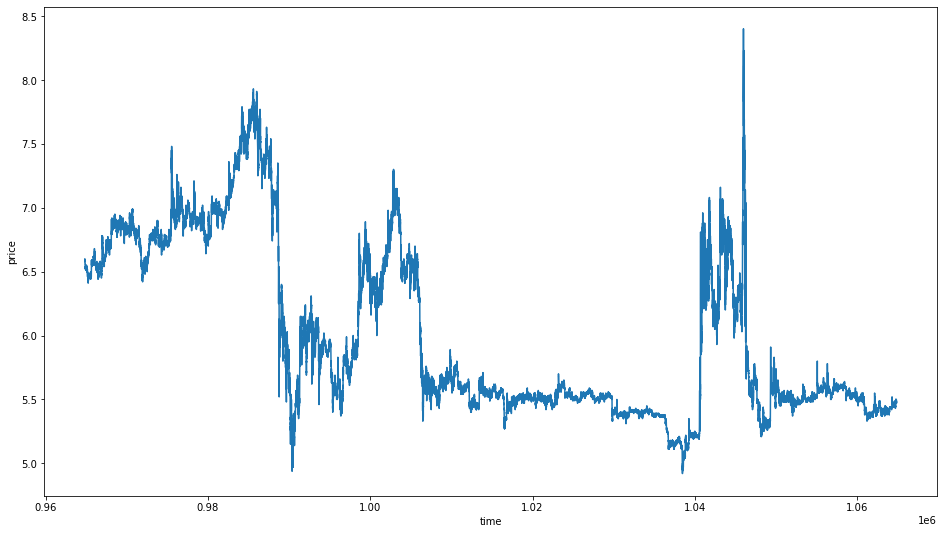

In [10]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['Close'], x=df.index)
plt.xlabel('time')
plt.ylabel('price')

In [11]:
scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'quote_av',
       'trades', 'tb_base_av', 'tb_quote_av', 'Return',
       'Maximum Hour Return', 'Price Volatility', 'Return Volatility',
       'Momentum 1H', 'Momentum 3H', 'Momentum 4H', 'Momentum 12H',
       'Momentum 24H', 'Maximum Daily Return', 'Avg Price']
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])

df = pd.DataFrame(scaled, columns=scale_cols)
print(df)

           Open      High       Low     Close    Volume  quote_av    trades  \
0      0.484058  0.479769  0.486957  0.477011  0.000131  0.000123  0.001071   
1      0.484058  0.479769  0.492754  0.482759  0.000202  0.000191  0.001428   
2      0.484058  0.479769  0.492754  0.482759  0.000000  0.000000  0.000000   
3      0.484058  0.479769  0.492754  0.482759  0.000023  0.000022  0.000357   
4      0.484058  0.479769  0.492754  0.482759  0.000000  0.000000  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
99995  0.159420  0.156069  0.168116  0.160920  0.000000  0.000000  0.000000   
99996  0.156522  0.156069  0.165217  0.158046  0.004716  0.003689  0.005353   
99997  0.159420  0.158960  0.168116  0.163793  0.003324  0.002606  0.007138   
99998  0.159420  0.156069  0.168116  0.160920  0.000906  0.000710  0.001428   
99999  0.159420  0.156069  0.168116  0.160920  0.000857  0.000672  0.004283   

       tb_base_av  tb_quote_av    Return  Maximum H

In [12]:
6.58/0.477011

13.794231160287708

In [13]:
# 모델 생성 함수

def create_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=8, padding="causal", activation="relu", input_shape=input_shape),
        LSTM(16, activation='tanh'),
        Dense(16, activation="relu"),
        Dense(1)
    ])
    loss = Huber()
    optimizer = Adam(0.00005)
    model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
    return model

In [14]:
def windowed_dataset(x, y, window_size, batch_size, shuffle):
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))
    ds_y = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

In [15]:
# Parameters
WINDOW_SIZE = 5
BATCH_SIZE = 32

In [16]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(df, df['Close'], test_size=0.1, random_state=0, shuffle=False)


In [17]:
from sklearn.metrics import mean_squared_error

In [18]:
predicted = []

for i in range(1, 11):
    train_data = windowed_dataset(x_train, y_train, WINDOW_SIZE + i - 1, BATCH_SIZE, True)
    model = create_model([WINDOW_SIZE + i - 1, df.shape[1]])
    earlystopping = EarlyStopping(monitor='loss', patience=35)
    filename = os.path.join('tmp', f'ckeckpointer_step_{i}.ckpt')
    checkpoint = ModelCheckpoint(filename, 
                                 save_weights_only=True, 
                                 save_best_only=True, 
                                 monitor='loss', 
                                 verbose=1)
    history = model.fit(train_data, epochs=1, callbacks=[checkpoint, earlystopping])

    model.load_weights(filename)
    window = x_train[-(WINDOW_SIZE + i - 1):].values.reshape(1, WINDOW_SIZE + i - 1, -1)
    pred = model.predict(window)
    predicted.append(pred[0, 0])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
   2803/Unknown - 10s 3ms/step - loss: 0.0019 - mse: 0.0038
Epoch 1: loss improved from inf to 0.00191, saving model to tmp\ckeckpointer_step_1.ckpt
1/1 [==============================] - 0s 309ms/step
   2809/Unknown - 11s 3ms/step - loss: 0.0032 - mse: 0.0065
Epoch 1: loss improved from inf to 0.00324, saving model to tmp\ckeckpointer_step_2.ckpt
1/1 [==============================] - 0s 282ms/step
   2809/Unknown - 11s 3ms/step - loss: 0.0010 - mse: 0.0020
Epoch 1: loss improved from inf to 0.00100, saving model to tmp\ckeckpointer_step_3.ckpt
1/1 [==============================] - 0s 308ms/step
   2802/Unknown - 12s 4ms/step - loss: 0.0023 - mse: 0.0046
Epoch 1: loss improved from inf to 0.00231, saving model to tmp\ckeckpointer_step_4.ckpt
1/1 [==============================] - 0s 33

In [19]:
print(f"Predicted values: {predicted}")
print(f"Actual values: {y_test[:10].values}")
print(f"MSE: {mean_squared_error(y_test[:10].values, predicted)}")

Predicted values: [0.16844918, 0.16867594, 0.16705118, 0.1667064, 0.168353, 0.16892518, 0.16721942, 0.16729863, 0.16997689, 0.16845047]
Actual values: [0.16954023 0.16954023 0.16954023 0.16954023 0.16954023 0.16954023
 0.17241379 0.17241379 0.17241379 0.17241379]
MSE: 9.274397832789323e-06


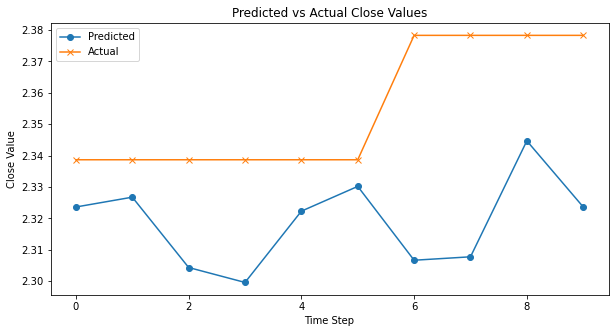

In [21]:
import matplotlib.pyplot as plt

# predicted와 y_test[:5]를 31016으로 곱함
predicted_scaled = [p * (13.794231160287708) for p in predicted[:10]]
actual_scaled = [a * (13.794231160287708) for a in y_test[:10].values]

# 그래프를 그림
plt.figure(figsize=(10, 5))
plt.plot(predicted_scaled, label="Predicted", marker='o')
plt.plot(actual_scaled, label="Actual", marker='x')
plt.xlabel('Time Step')
plt.ylabel('Close Value')
plt.legend()
plt.title('Predicted vs Actual Close Values')
plt.show()

# 아.. 그저 "쓰레기코인"!